In [3]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

1. Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” –malicious). Описание данных доступно на сайте https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [4]:
breasts = pd.read_csv(r'data_breast.csv')
breasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
# отделим таргет от фич. Последняя колонка пустая, поэтому дроп
diagnosis = breasts.diagnosis
cols_to_drop = ['id','diagnosis', breasts.columns[-1]]
features = breasts.drop(cols_to_drop, axis = 1)

In [6]:
features.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [8]:
# заменим benign на 1, malicious на 0
diagnosis = diagnosis.apply(lambda x: 1 if x == 'B' else 0)
diagnosis.value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

2. Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [9]:
# среднее уже посчитано в исходном датасете
# остальные характеристики (медиана, среднее отклонение, min/max) рассчитает describe() + добавим несколько статистик к нему 

# stats = breasts.describe()
# stats.append(breasts.drop(['id','diagnosis'], axis=1).agg(['median']), sort=True)
features.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


3. Выбрать стратегию для работы с пропущенными значениями.

In [10]:
# breasts.info() после дропа последней пустой безымянной колонки показывает, что пропущенных значений в датасете нет
# можно взглянуть, сколько нулевых значений
features.apply(lambda x: (x == 0).value_counts())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
False,569.0,569.0,569.0,569.0,569.0,569.0,556,556,569.0,569.0,...,569.0,569.0,569.0,569.0,569.0,569.0,556,556,569.0,569.0
True,NaN,NaN,NaN,NaN,NaN,NaN,13,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13,13,NaN,NaN


4. Рассчитать и визуализировать корреляционную матрицу для переменных.

In [11]:
corr_matrix = breasts.drop(['id', breasts.columns[-1]], axis=1).corr()
# corr_matrix
corr_matrix["radius_mean"].sort_values(ascending=False)

radius_mean                1.000000
perimeter_mean             0.997855
area_mean                  0.987357
radius_worst               0.969539
perimeter_worst            0.965137
area_worst                 0.941082
concave points_mean        0.822529
concave points_worst       0.744214
area_se                    0.735864
radius_se                  0.679090
concavity_mean             0.676764
perimeter_se               0.674172
concavity_worst            0.526911
compactness_mean           0.506124
compactness_worst          0.413463
concave points_se          0.376169
texture_mean               0.323782
texture_worst              0.297008
compactness_se             0.206000
concavity_se               0.194204
smoothness_mean            0.170581
symmetry_worst             0.163953
symmetry_mean              0.147741
smoothness_worst           0.119616
fractal_dimension_worst    0.007066
fractal_dimension_se      -0.042641
texture_se                -0.097317
symmetry_se               -0

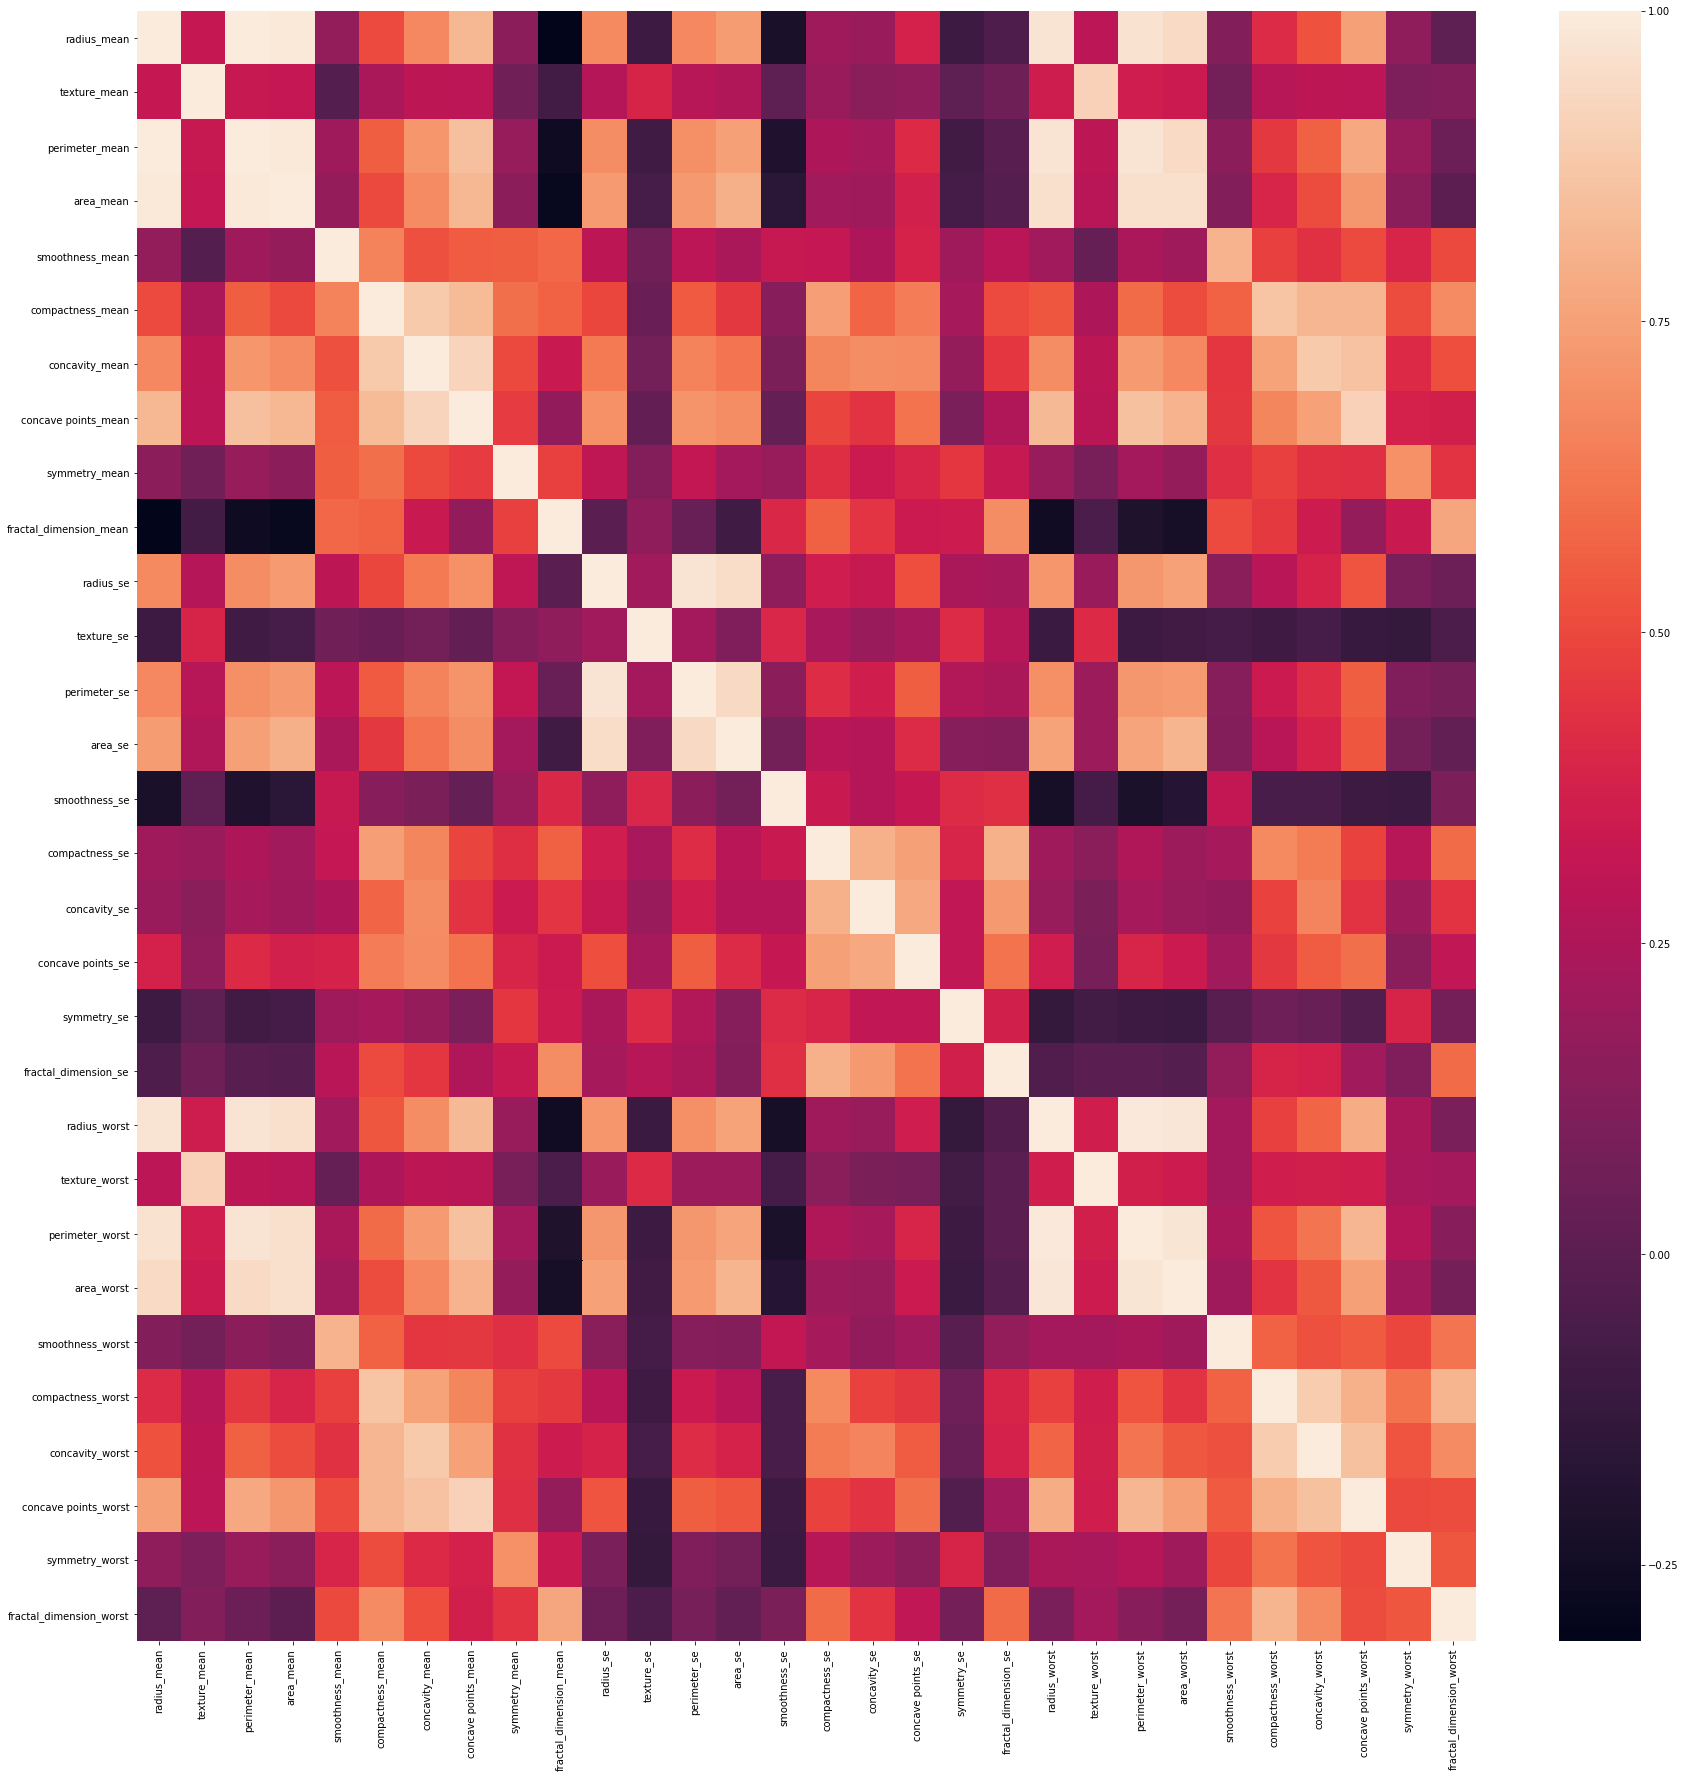

In [12]:
plt.figure(figsize=corr_matrix.shape) 
sns.heatmap(corr_matrix)

5. Визуализировать взаимосвязи между переменными (scatter plots, гистограммы, …).

In [13]:
# from pandas.plotting import scatter_matrix

# attributes = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']
# _ = scatter_matrix(train_set[attributes], figsize=(15, 10))

C:\Users\Sony\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


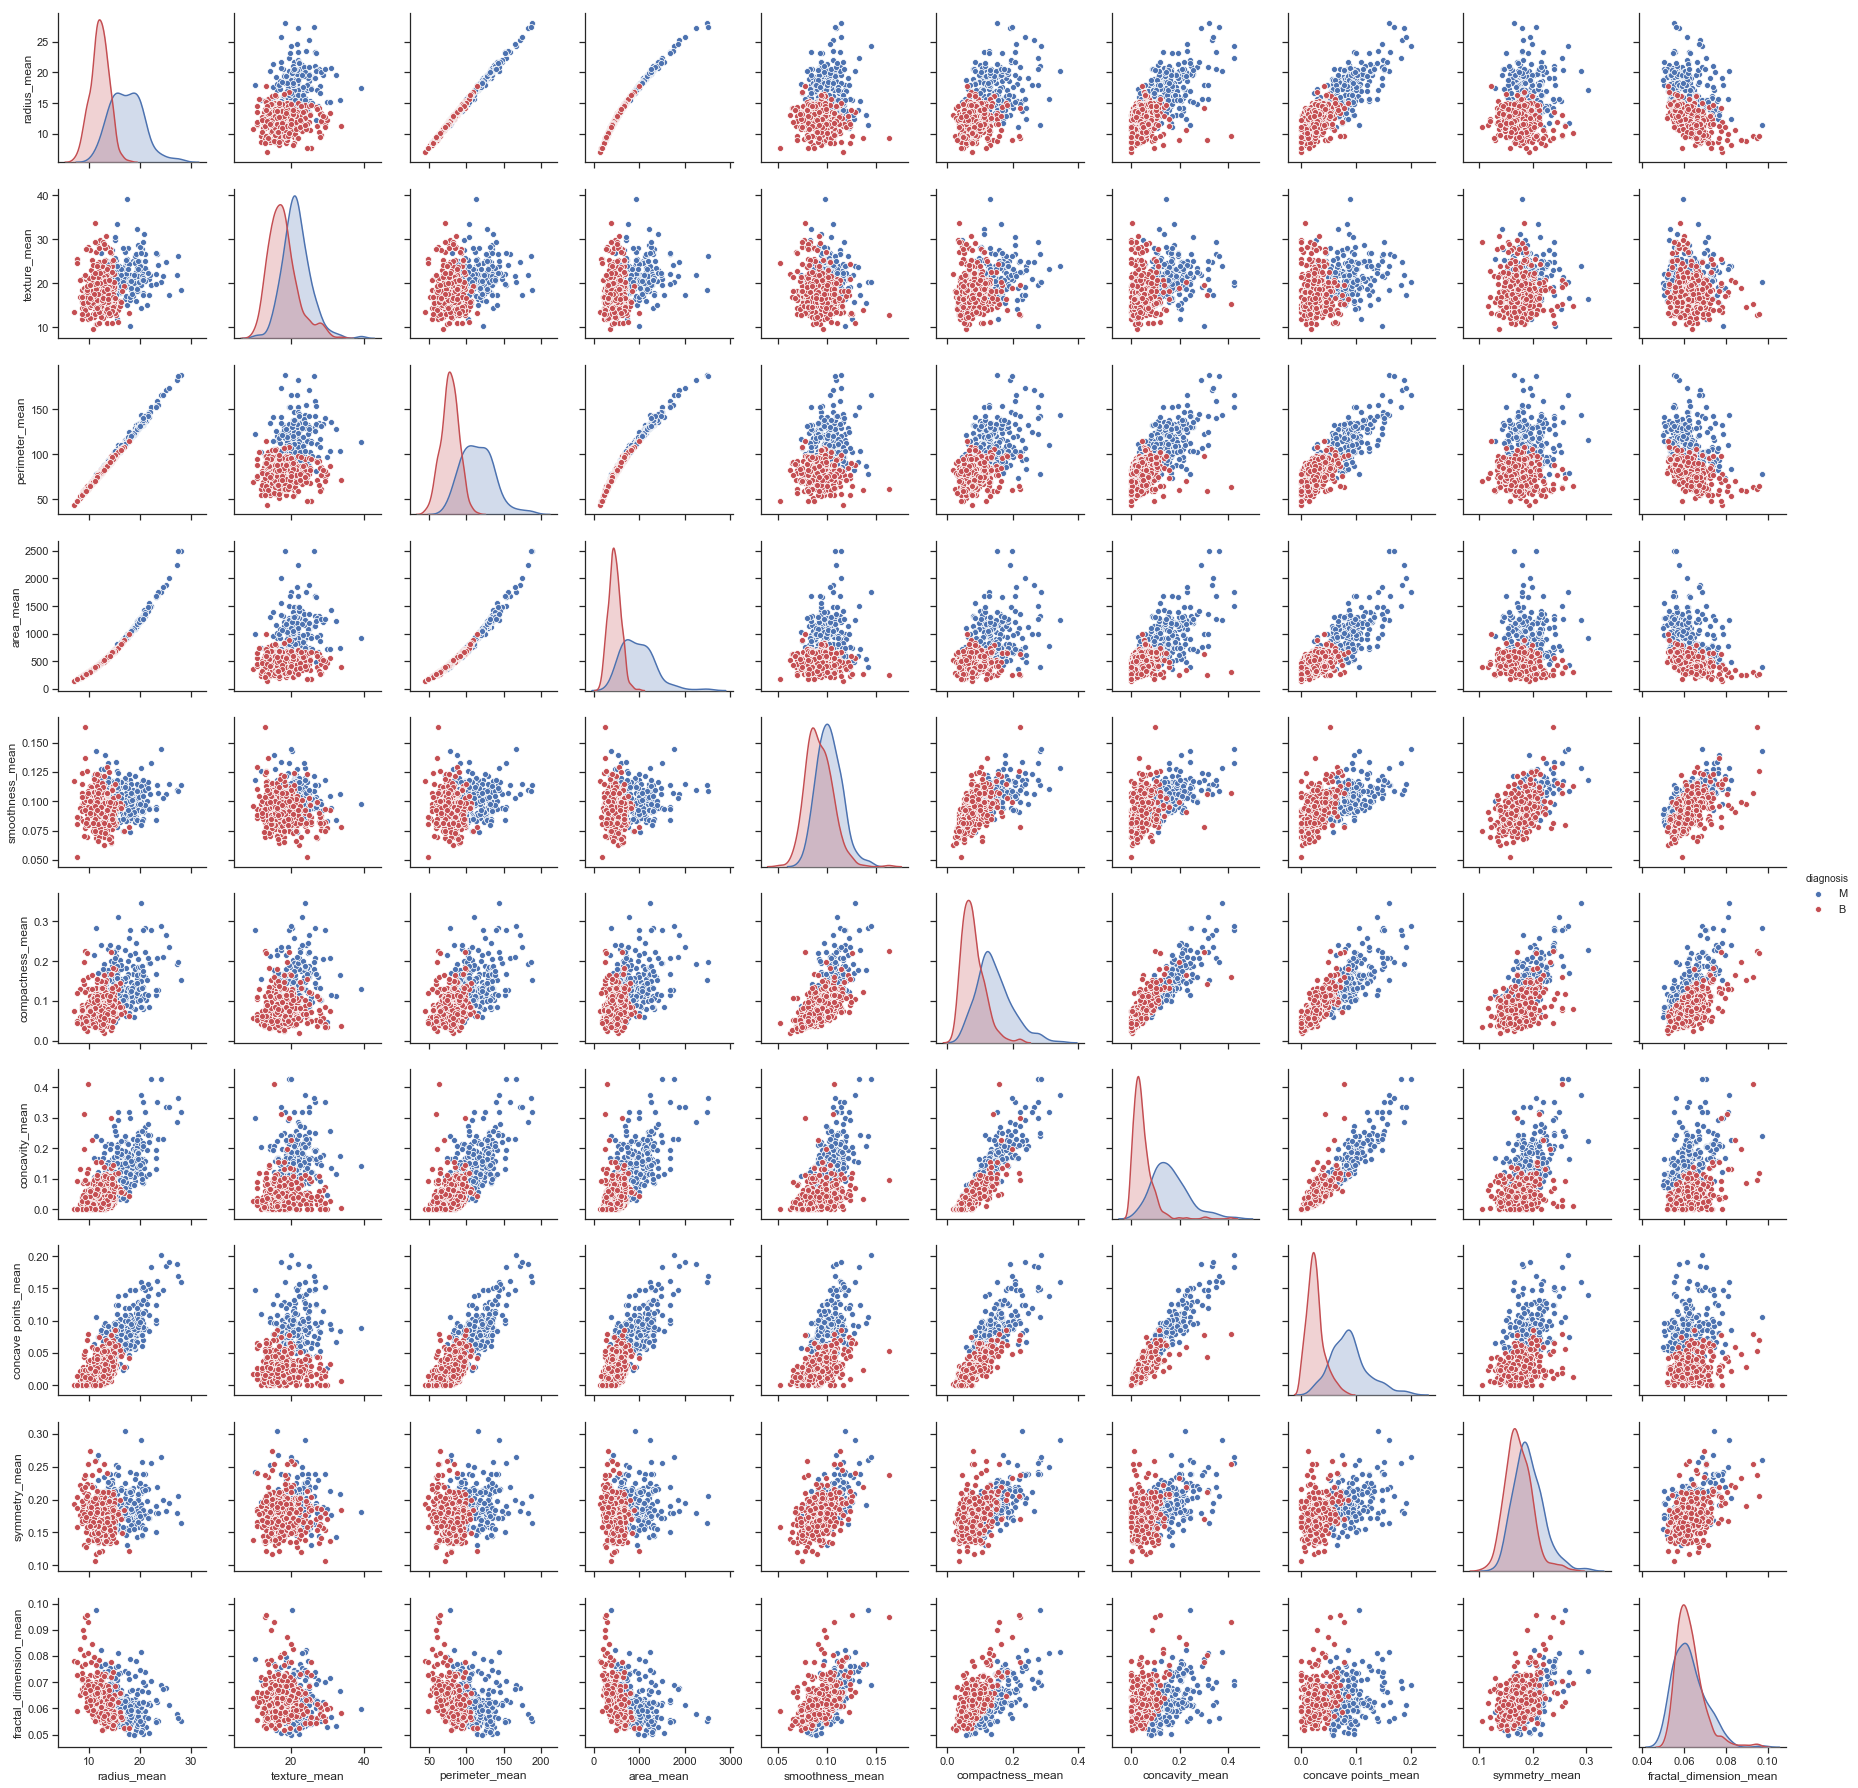

In [14]:
attributes = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']

sns.set(style='ticks')
sns.pairplot(breasts[attributes], palette=('b', 'r'), hue = 'diagnosis')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010089B70>,
      dtype=object)

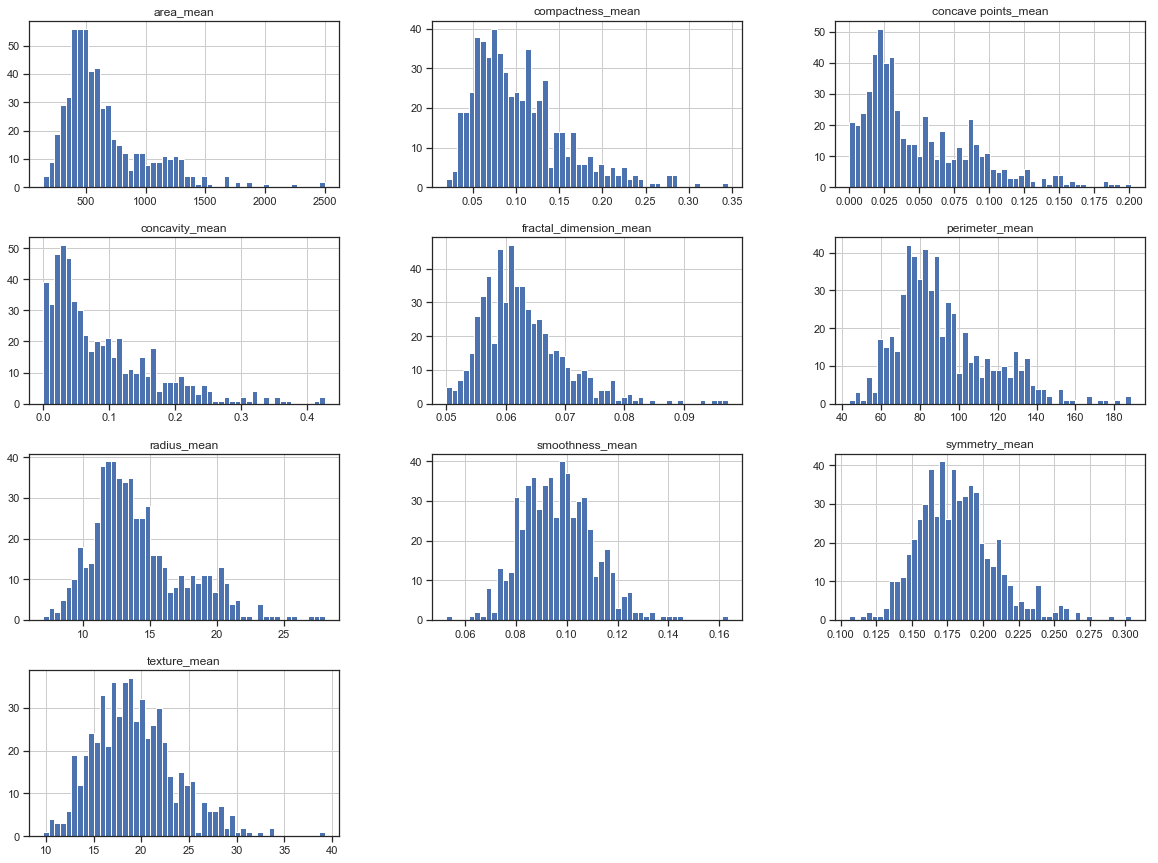

In [15]:
features[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']].hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000109FA390>,
      dtype=object)

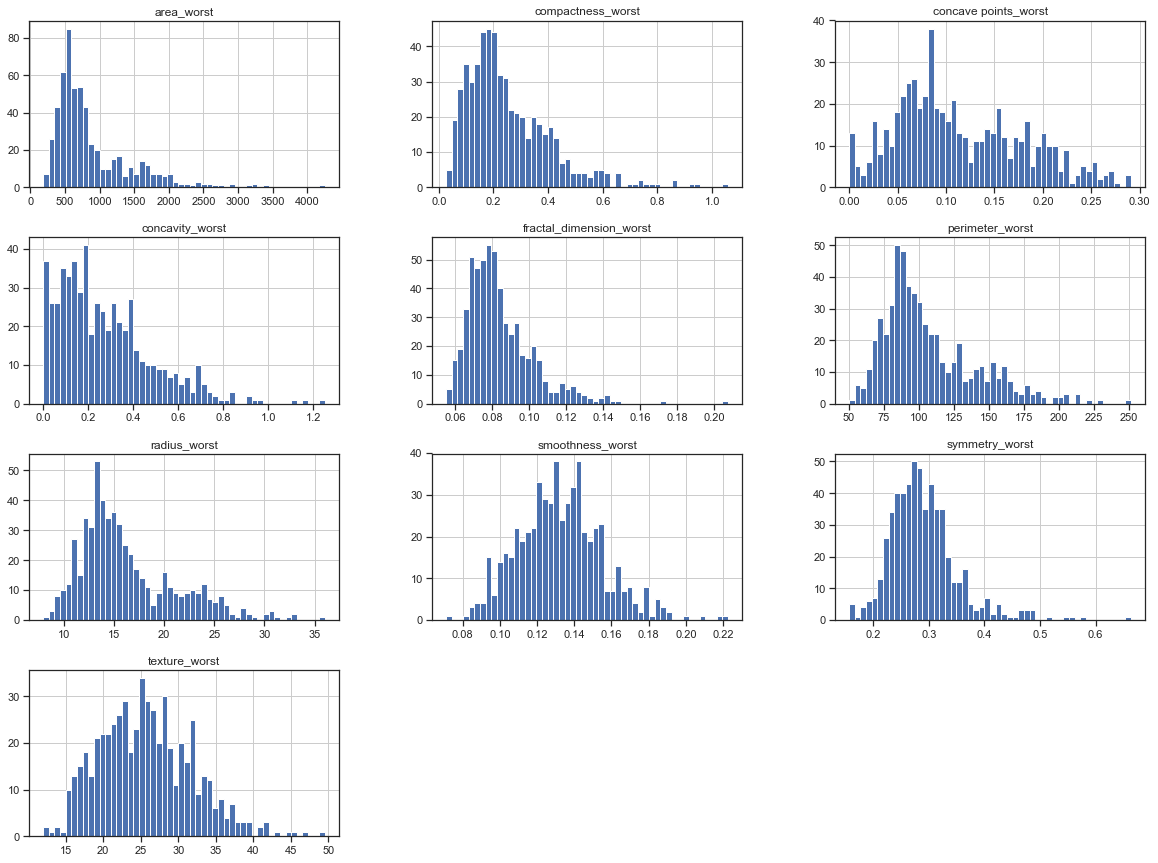

In [16]:
features[['radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].hist(bins=50, figsize=(20,15))

6. С помощью статистических методов проверить взаимосвязи между переменными.

In [17]:
practice 3_1

SyntaxError: invalid syntax (<ipython-input-17-7912b1ae66e9>, line 1)

7. Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

### reduce using PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
y = diagnosis
x = features
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.3, random_state=42)

In [21]:
scaler = StandardScaler()
x_scaled = scaler.fit(x_train)
x_train_scaled=  x_scaled.transform(x_train)
x_test_scaled = x_scaled.transform(x_test)

In [41]:
pca = PCA(n_components=15)

In [42]:
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
X_pca = pca.transform(x_train_scaled)

In [44]:
for i in range(1, X_pca.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.452
n-components=2, explained variance 0.648
n-components=3, explained variance 0.737
n-components=4, explained variance 0.803
n-components=5, explained variance 0.858
n-components=6, explained variance 0.898
n-components=7, explained variance 0.919
n-components=8, explained variance 0.934
n-components=9, explained variance 0.946
n-components=10, explained variance 0.956
n-components=11, explained variance 0.965
n-components=12, explained variance 0.973
n-components=13, explained variance 0.980
n-components=14, explained variance 0.985
n-components=15, explained variance 0.988


*15 компонент объяснили почти 99% дисперсии в данных.*

Text(0,0.5,'explained_variance_ratio_')

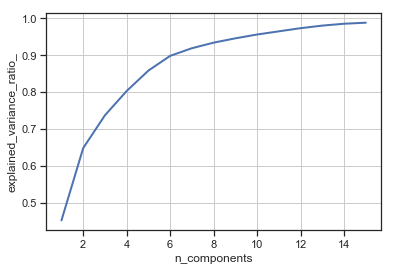

In [45]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [50]:
X_train_pca = X_pca
X_test_pca = pca.transform(x_test_scaled)

#### как вариант, расчет feature importance

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
model= ExtraTreesClassifier()
model.fit(features, diagnosis)
print(model.feature_importances_)

[0.04710231 0.02768613 0.01566855 0.09049866 0.01479053 0.00562748
 0.0625654  0.06528904 0.01177565 0.00521088 0.04700094 0.00400716
 0.03975626 0.01535424 0.01053605 0.0079862  0.00727547 0.00210832
 0.00934044 0.00622792 0.14203368 0.01202344 0.07425515 0.07328963
 0.02167834 0.04948148 0.079087   0.02815428 0.01339078 0.01079859]


C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


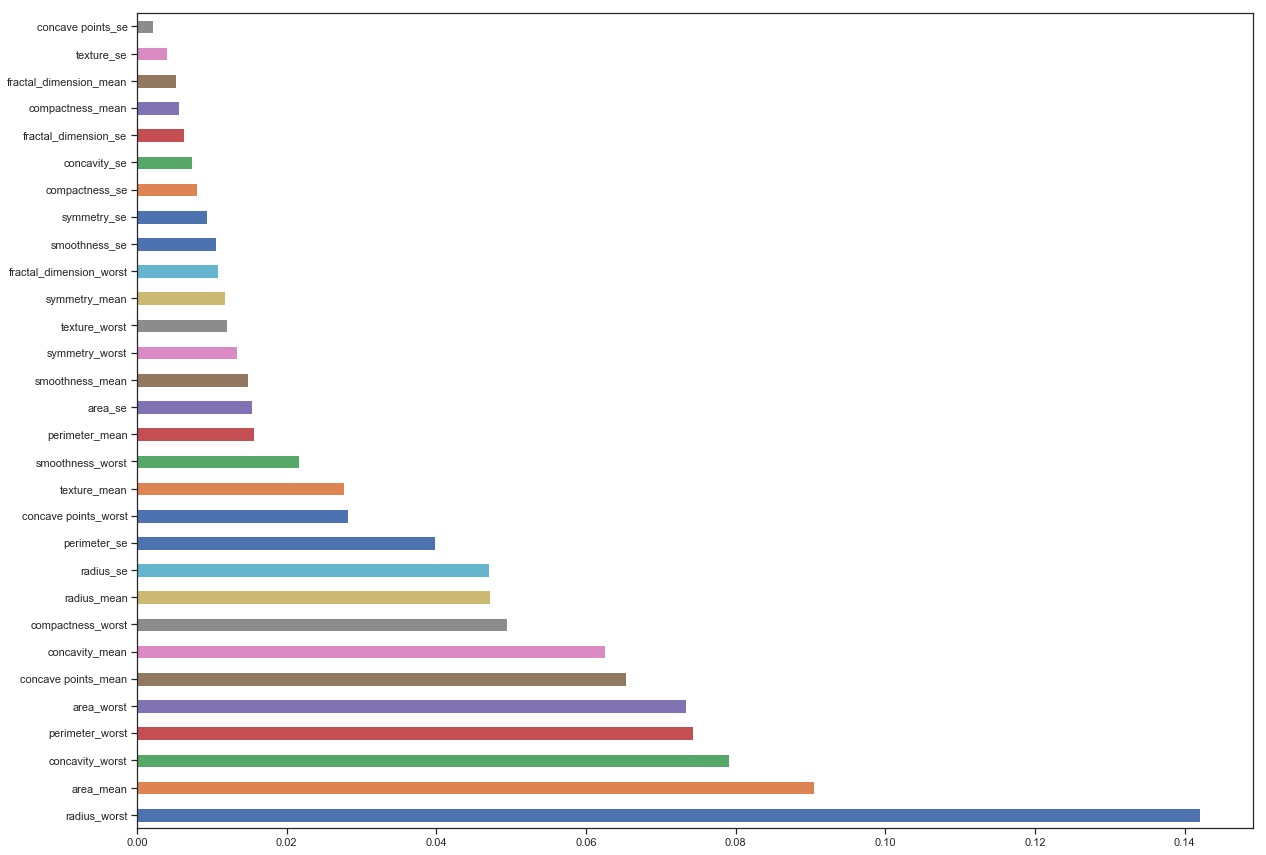

In [48]:
(pd.Series(model.feature_importances_,index=features.columns)
    .nlargest(30)
    .plot(kind='barh',figsize=(20,15)))

In [49]:
not_important_features=['smoothness_se','fractal_dimension_se','texture_se','fractal_dimension_mean','symmetry_se','compactness_worst',
                  'compactness_se','smoothness_mean','symmetry_mean','texture_mean','concavity_se','texture_worst','area_se',
                  'concave points_se','fractal_dimension_worst','perimeter_worst','smoothness_worst','symmetry_worst','compactness_mean']
important_features = features.drop(not_important_features, axis=1)
important_features.head()

,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,radius_worst,area_worst,concavity_worst,concave points_worst
0,17.99,122.80,1001.0,0.3001,0.14710,1.0950,8.589,25.38,2019.0,0.7119,0.2654
1,20.57,132.90,1326.0,0.0869,0.07017,0.5435,3.398,24.99,1956.0,0.2416,0.1860
2,19.69,130.00,1203.0,0.1974,0.12790,0.7456,4.585,23.57,1709.0,0.4504,0.2430
3,11.42,77.58,386.1,0.2414,0.10520,0.4956,3.445,14.91,567.7,0.6869,0.2575
4,20.29,135.10,1297.0,0.1980,0.10430,0.7572,5.438,22.54,1575.0,0.4000,0.1625


8. Рассчитать Feature Selection для выбранных переменных.

9. Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса.

### Построение модели

In [52]:
from sklearn.svm import SVC

In [53]:
x = X_train_pca.copy()
y = y_train.copy()
svm = SVC(kernel='rbf',random_state = 0, gamma = 90.0, C=100.0)
svm.fit(x,y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=90.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [54]:

svm.score(X_test_pca,y_test)

0.6257309941520468

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [64]:
rf = RandomForestClassifier(n_estimators=150, random_state=11)
rf.fit(x, y)
rf.score(X_test_pca,y_test)

0.9532163742690059

In [66]:
score = LogisticRegression(solver='liblinear').fit(x,y).score(X_test_pca,y_test)
score

0.9707602339181286

In [67]:
xgb = xgboost.XGBClassifier(max_depth=4, n_jobs=-1)
xgb.fit(x, y)
y_train_predict = xgb.predict_proba(x)[:, 1]
y_test_predict = xgb.predict_proba(X_test_pca)[:, 1]
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  1.0


In [68]:
xgb.score(X_test_pca,y_test)

0.9824561403508771

**XGBClassifier дает лучшие результаты из всех моделей**

10. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall.

### Проверим качество на первоначальных данных

In [70]:
y = diagnosis
x = features
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.3, random_state=42)

In [71]:
x = x_train.copy()
y = y_train.copy()
x_t = x_test.copy()
y_t = y_test.copy()

xgb = xgboost.XGBClassifier(max_depth=4, n_jobs=-1)
xgb.fit(x, y)
y_train_predict = xgb.predict_proba(x)[:, 1]
y_test_predict = xgb.predict_proba(x_t)[:, 1]
roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_t, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.99


In [72]:
xgb.score(x_t,y_t)

0.9590643274853801

Качество на первоначальных данных оказалось чуть ниже (на 2,34%)

In [74]:
score = LogisticRegression(solver='liblinear').fit(x,y).score(x_t, y_t)
score

0.9415204678362573

Также и для логистической регрессии.